# YOLOv5

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

# YOLOv8

In [ ]:
!pip install ultralytics
!pip install opencv-python-headless
!pip install dill

In [ ]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
!pip install -e .

# Librerias e Importaciones

In [ ]:
pip install fiftyone

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Librerías estándar de Python
import os
import shutil
import random
import json
from pathlib import Path

# Librerías de procesamiento de imágenes y visualización
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Librerías de aprendizaje automático y manejo de datos
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import albumentations as A

#Librerias para Visualizar el dataset
import fiftyone as fo
import fiftyone.zoo as foz

# Directorios dataset

In [ ]:
base_dir = '/content/your_path'

train_dir = os.path.join(base_dir, 'train')
train_images_dir = os.path.join(train_dir, 'images')
train_labels_dir = os.path.join(train_dir, 'labels')

val_images_dir = os.path.join(base_dir, 'val/images')
val_labels_dir = os.path.join(base_dir, 'val/labels')

test_images_dir = os.path.join(base_dir, 'test/images')
test_labels_dir = os.path.join(base_dir, 'test/labels')

augmented_dir = os.path.join(base_dir, 'augmented')
augmented_images_dir = os.path.join(augmented_dir, 'images')
augmented_labels_dir = os.path.join(augmented_dir, 'labels')


label_errors_dir = os.path.join(base_dir, 'label_errors')

In [ ]:
# Conjunto Train
num_valid_images_train = len(os.listdir(train_images_dir))
num_valid_labels_train = len(os.listdir(train_labels_dir))
print(f"Number of valid images train left: {num_valid_images_train}")
print(f"Number of valid labels train left: {num_valid_labels_train}")

print("--------------------------------------------------------------")

# Conjunto Validacion
num_valid_images_val = len(os.listdir(val_images_dir))
num_valid_labels_val = len(os.listdir(val_labels_dir))
print(f"Number of valid images validation left: {num_valid_images_val}")
print(f"Number of valid labels validation left: {num_valid_labels_val}")

print("--------------------------------------------------------------")

# Conjunto Test
num_valid_images_test = len(os.listdir(test_images_dir))
num_valid_labels_test = len(os.listdir(test_labels_dir))
print(f"Number of valid images test left: {num_valid_images_test}")
print(f"Number of valid labels test left: {num_valid_labels_test}")

Number of valid images train left: 777
Number of valid labels train left: 777
--------------------------------------------------------------
Number of valid images validation left: 0
Number of valid labels validation left: 0
--------------------------------------------------------------
Number of valid images test left: 0
Number of valid labels test left: 0


In [ ]:
# Listamos los archivos en los directorios correspondientes
image_files = {os.path.splitext(f)[0]: f for f in os.listdir(train_images_dir) if f.endswith(('.png'))}
label_files = {os.path.splitext(f)[0]: f for f in os.listdir(train_labels_dir) if f.endswith('.txt')}

# Encuentra imágenes que no tienen etiquetas correspondientes
missing_labels = [img for img in image_files if img not in label_files]

print(f"Total de imágenes sin etiquetas: {len(missing_labels)}")
for img in missing_labels:
    print(f"Imagen sin etiqueta: {image_files[img]}")

Total de imágenes sin etiquetas: 0


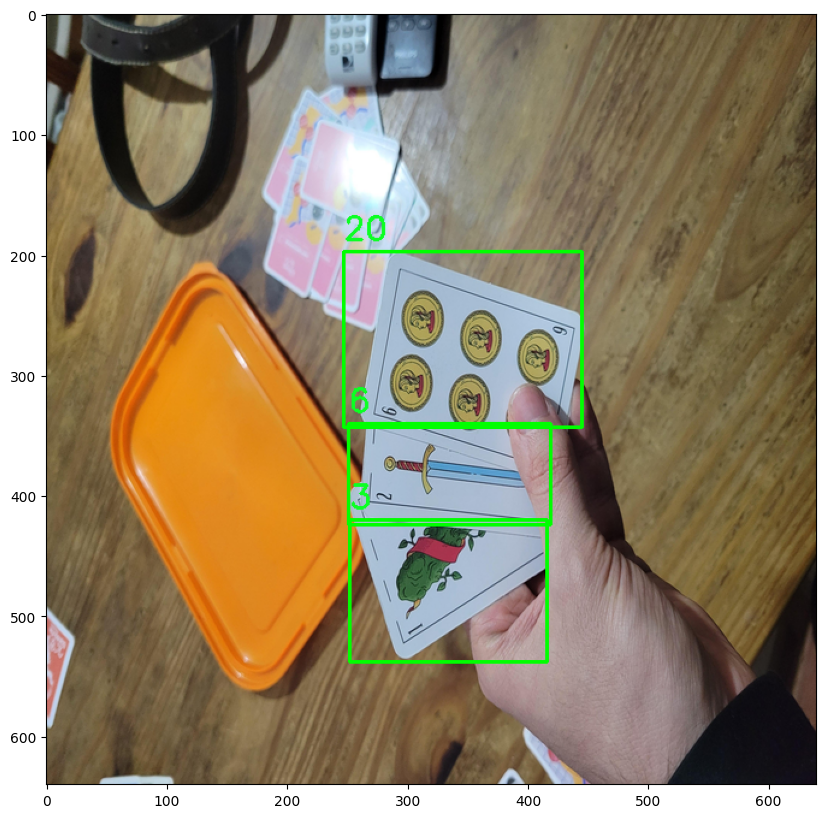

In [ ]:
def draw_boxes(image_path, label_path):
    # Lee la imagen
    image = cv2.imread(image_path)
    if image is None:
        print("No se pudo cargar la imagen.")
        return

    # Lee la etiqueta
    with open(label_path, 'r') as file:
        lines = file.readlines()

    # Obtiene dimensiones de la imagen
    height, width, _ = image.shape

    # Dibuja cada bounding box
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, box_width, box_height = map(float, parts[1:5])

        # Convierte coordenadas de YOLO a coordenadas de OpenCV
        x_center, y_center, box_width, box_height = x_center * width, y_center * height, box_width * width, box_height * height
        top_left_x = int(x_center - box_width / 2)
        top_left_y = int(y_center - box_height / 2)

        # Dibuja el rectángulo
        cv2.rectangle(image, (top_left_x, top_left_y), (int(top_left_x + box_width), int(top_left_y + box_height)), (0, 255, 0), 2)
        cv2.putText(image, str(class_id), (top_left_x, top_left_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Convierte BGR a RGB para matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.show()

# Rutas a los archivos de imagen y etiqueta
image_path = '/content/drive/your_path.png'
label_path = '/content/drive/your_path.txt'

# Llamar a la función
draw_boxes(image_path, label_path)

# Validacion de Bounding Boxes

In [ ]:
def validate_annotations(img_dir, label_dir, output_dir):
    for label_file in os.listdir(label_dir):
        img_file = label_file.replace('.txt', '.png')
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, label_file)

        with open(label_path, 'r') as file:
            lines = file.readlines()

        valid = True
        for line in lines:
            data = line.strip().split()
            class_id, x_center, y_center, width, height = map(float, data[:5])
            if x_center - width / 2 < 0 or y_center - height / 2 < 0 or x_center + width / 2 > 1 or y_center + height / 2 > 1:
                valid = False
                break

        if not valid:
            shutil.move(label_path, os.path.join(output_dir, label_file))
            shutil.move(img_path, os.path.join(output_dir, img_file))

def unify_annotations(label_dir):
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        new_lines = []
        with open(label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                data = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, data[:5])
                # Formato YOLOv5
                new_line = f"{int(class_id)} {x_center} {y_center} {width} {height}\n"
                new_lines.append(new_line)
        with open(label_path, 'w') as file:
            file.writelines(new_lines)

# Validamos las anotaciones y movemos los archivos erroneos
validate_annotations(train_images_dir, train_labels_dir, label_errors_dir)

# Unificamos las anotaciones
unify_annotations(train_labels_dir)

# Verificamos la salida
print(f"Validacion y unificacion completada. Chequea {label_errors_dir} por ningun archivo erroneo.")

In [ ]:
print("--------------------------------------------------------------")
# Conjunto de Archivos erroneos
num_errors = len(os.listdir(label_errors_dir))
print(f"Number of files in label_errors folder: {num_errors}")
print("--------------------------------------------------------------")

--------------------------------------------------------------
Number of files in label_errors folder: 174
--------------------------------------------------------------


# Aumentacion de Dataset

In [ ]:
# Definimos las transformaciones
transformations = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.ToGray(p=0.1),
    A.RGBShift(p=0.5),
    A.RandomGamma(p=0.5),
    A.ChannelShuffle(p=0.1),
    A.CLAHE(p=0.5),
    A.RandomToneCurve(p=0.5),
    A.Equalize(p=0.5),
    A.ColorJitter(p=0.5),
    A.Solarize(p=0.5)
])

# Número de imágenes aumentadas por imagen original
num_augmented_per_image = 6

def process_image(image_file, image_dir, label_dir):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {image_file}")
        return

    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(label_dir, label_file)
    if not os.path.exists(label_path):
        print(f"Label not found for {image_file}")
        return

    with open(label_path, 'r') as file:
        labels = file.read()

    for i in range(num_augmented_per_image):
        augmented = transformations(image=image)
        aug_image = augmented['image']
        aug_image_file = os.path.join(augmented_images_dir, f'aug_{i}_{image_file}')
        cv2.imwrite(aug_image_file, aug_image)
        aug_label_file = os.path.join(augmented_labels_dir, f'aug_{i}_{label_file}')
        with open(aug_label_file, 'w') as file:
            file.write(labels)

# Aplicamos aumento y copiamos archivos
for file in os.listdir(train_images_dir):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        process_image(file, train_images_dir, train_labels_dir)

print("Data augmentation and splitting completed.")

Data augmentation and splitting completed.


# Division del Dataset

In [ ]:
def split_data(image_dir, label_dir, train_ratio=0.7, val_ratio=0.2):
    # Listamos todos los archivos
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    image_files.sort()  # Ordenamos para garantizar el orden de las etiquetas

    # Dividimos los datos
    train_val_files, test_files = train_test_split(image_files, test_size=(1 - train_ratio - val_ratio), random_state=42)
    train_files, val_files = train_test_split(train_val_files, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

    # Funcion para mover los archivos de forma segura
    def move_files(files, src_image_dir, src_label_dir, dest_image_dir, dest_label_dir):
        for file in files:
            src_image_path = os.path.join(src_image_dir, file)
            src_label_path = os.path.join(src_label_dir, file.replace('.png', '.txt'))
            dest_image_path = os.path.join(dest_image_dir, file)
            dest_label_path = os.path.join(dest_label_dir, file.replace('.png', '.txt'))

            # Aseguramos de que existan los archivos de orgien
            if os.path.exists(src_image_path) and os.path.exists(src_label_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_label_path, dest_label_path)
            else:
                print(f"Missing file: {src_image_path} or {src_label_path}")

    # Movemos los archivos
    move_files(train_files, image_dir, label_dir, train_images_dir, train_labels_dir)
    move_files(val_files, image_dir, label_dir, val_images_dir, val_labels_dir)
    move_files(test_files, image_dir, label_dir, test_images_dir, test_labels_dir)

split_data(augmented_images_dir, augmented_labels_dir)

In [ ]:
# Verificamos el número de archivos en cada conjunto
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

print(f"Imágenes aumentadas: {count_files(augmented_images_dir)}")
print(f"Etiquetas aumentadas: {count_files(augmented_labels_dir)}")

print("--------------------------------------------------------------")

print(f"Imágenes de entrenamiento: {count_files(train_images_dir)}")
print(f"Etiquetas de entrenamiento: {count_files(train_labels_dir)}")

print("--------------------------------------------------------------")

print(f"Imágenes de validación: {count_files(val_images_dir)}")
print(f"Etiquetas de validación: {count_files(val_labels_dir)}")

print("--------------------------------------------------------------")

print(f"Imágenes de test: {count_files(test_images_dir)}")
print(f"Etiquetas de test: {count_files(test_labels_dir)}")

Imágenes aumentadas: 0
Etiquetas aumentadas: 0
--------------------------------------------------------------
Imágenes de entrenamiento: 4038
Etiquetas de entrenamiento: 4038
--------------------------------------------------------------
Imágenes de validación: 933
Etiquetas de validación: 933
--------------------------------------------------------------
Imágenes de test: 467
Etiquetas de test: 467


# Visualizacion del dataset

In [ ]:
def load_fiftyone_dataset(images_dir, labels_dir, name):
    dataset = fo.Dataset(name)

    for image_file in os.listdir(images_dir):
        if image_file.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(images_dir, image_file)
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file)

            detections = []
            with open(label_path, 'r') as file:
                for line in file:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    detections.append(
                        fo.Detection(
                            label=str(int(class_id)),
                            bounding_box=[x_center - width / 2, y_center - height / 2, width, height]
                        )
                    )

            sample = fo.Sample(filepath=image_path, ground_truth=fo.Detections(detections=detections))
            dataset.add_sample(sample)

    return dataset


# cargamos el dataset enFiftyOne
test_dataset = load_fiftyone_dataset(test_images_dir, test_labels_dir, "test_dataset")

combined_dataset = fo.Dataset("combined_dataset")
combined_dataset.merge_samples(test_dataset)

# Lanzamos la aplicacion FiftyOne
session = fo.launch_app(combined_dataset)

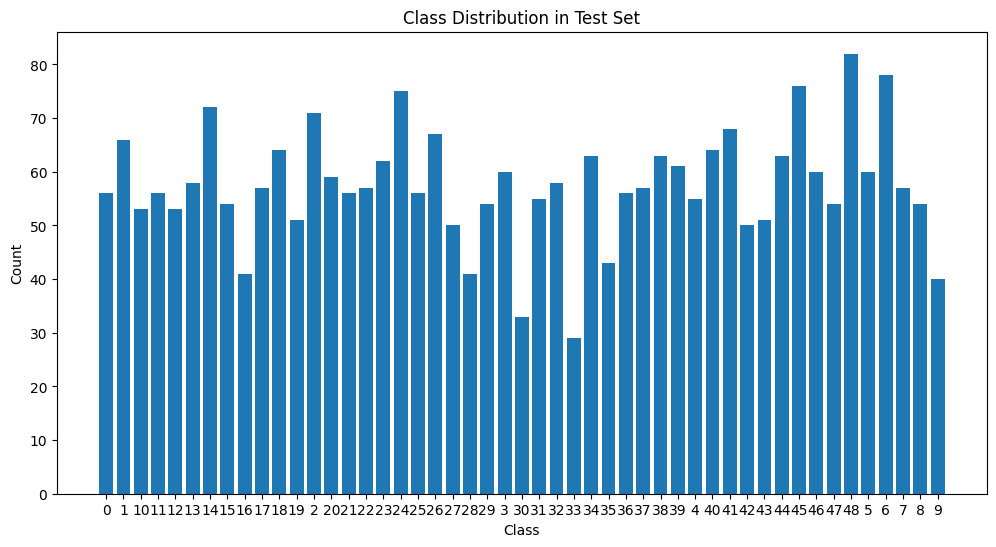

In [ ]:
# Funcion para contar las clases
def count_classes(dataset):
    classes = {}
    for sample in dataset:
        for detection in sample.ground_truth.detections:
            label = detection.label
            if label in classes:
                classes[label] += 1
            else:
                classes[label] = 1
    return classes

#contamos las clases en el dataset
test_classes = count_classes(test_dataset)

# funcion para visualizacion
def plot_class_distribution(class_counts, title):
    labels, counts = zip(*sorted(class_counts.items()))
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_class_distribution(test_classes, "Class Distribution in Test Set")

# Entrenamiento del modelo YOLOv5 Small

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/drive/your_path/dataset.yaml --weights yolov5s.pt --cache --workers 2 --save-period 10 --project /content/drive/your_path --name model_training

2024-07-23 20:19:51.319606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 20:19:51.319668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 20:19:51.455975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/final_dataset_lomen/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device

# Test del modelo YOLOv5 Small

In [ ]:
!python detect.py --weights /content/drive/your_path/weights/best.pt --img 640 --conf 0.25 --source /content/drive/your_path/images/val

detect: weights=['/content/drive/MyDrive/model_training_2/weights/best.pt'], source=/content/drive/MyDrive/alumnos_practico/data/eval/images/val, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-347-gd6112173 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7142278 parameters, 0 gradients, 16.2 GFLOPs
image 1/32 /content/drive/MyDrive/alumnos_practico/data/eval/images/val/IMG_20240630_173711753_HDR.jpg: 640x512 1 11C, 394.3ms
image 2/32 /content/drive/MyDrive/alumnos_practico/data/eval/images/val/IMG_20240630_173737533.jpg: 640x512 1 1C, 1 2B, 1 5C, 368.4ms
image 3/32 /content/drive/

# Test modelo YOLOv8 Medium

In [ ]:
# Cargamos el modelo
model = YOLO('/content/drive/your_path/best.pt')

In [ ]:
# Directorio de imágenes para evaluar
test_dir = '/content/drive/your_path/images/val'

# Directorio para guardar los resultados
output_dir = '/content/drive/your_path/resultados_deteccion'
os.makedirs(output_dir, exist_ok=True)

# Realizamos la detección
results = model(test_dir, conf=0.25, imgsz=640)

# Guardamos los resultados
for i, r in enumerate(results):
    im_path = Path(r.path)
    save_path = os.path.join(output_dir, f'result_{i}_{im_path.name}')
    r.save(save_path)
    print(f"Guardado: {save_path}")